## Vector data analysis

### Steps:
1. Read metadata which is coded in filenames:
    * Session ID: each csv file contains data generated by one person
    * Location: data was collected within our team (in future a study with students at three universities is planned
    * Variant: there are three different versions of visualization planned
    * Period: orientation or freelook, predict if label should be predicted
2. Load data from csv files:
    * Pitch, Yaw, Roll: these data is used to compute additional columns, Pitch is also used for extracting features 
    * Time, user position
3. Compute additional columns:
    * Diffs and Absolute Diffs: differences between angles which are adjacent in time, for instance yaw[t2] - yaw[t1], these columns are used for extracting features 
    * Seconds: data is giving each 0.1 second (10 rows contain data for 1 second), this column is used to visualize user data with time on x-axis
    * Split: index for splits, each user data is split into parts of maximal 20 seconds lenght (split_sec = 200, adjust if needed), splits can be used for clustering instead of whole user/period data entry
    * Seconds Split: this column is used to visualize split data with time on x-axis
4. Visualize Pitch, Yaw and Roll and angles differences for users/periods and for splits and export graphs as pngs
5. Calculate and visualize average angle differences for users/periods and export graphs as pngs
6. Extract features for clustering and compute clustering for users/periods and for splits (separately):
    * Compute true labels (0/1): orientation or freelook
    * Compute features
    * For splits: select only splits with at least 90% of normal lenght
    * Select features (standardize, drop features with 0s only, drop highly correlated features)
    * Perform clustering with K-Means (K=2, sklearn.cluster.KMeans)
    * Predict label for new data
    * Plot true lables with PCA (sklearn.decomposition.PCA)
    * Plot clusters with PCA 
    * Evaluate clusters comparing them with true labels (sklearn.metrics.adjusted_rand_score)
    * Display labels predicted for new data
    * Plot clusters + predicted labels with PCA 
    * Plot clusters + predicted labels in another color with PCA

### Adjusted rand score

RI = (TP + TN) / (TP + FP + TN + FN)

> The Rand Index (RI) computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
> The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:
> ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
> The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

<i>Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011</i>

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

### Import libraries

In [1]:
import glob
import os
import sys
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing, metrics, decomposition, cluster
from sklearn.linear_model import LogisticRegression

### Load data and add columns with metadata

In [2]:
# set own local project path
local_project_path = ''

# set directory path with csv files
dir_path = local_project_path + 'MachineLearning/movement_analysis/data/study_demo_data/'

def set_file_paths(ext):

        # set data path for all files with the given extension
        dir_paths = dir_path + '*' + ext
        file_paths = glob.glob(dir_paths)
        # check if any files are found
        if not file_paths:
            sys.exit("No files found, check the path")
        return file_paths

In [3]:
# compute differences for adjacent (in time) yaw, pitch and roll angles
def calculate_diffs(user_data_temp):
    print('calculating diffs...')
    for i in range(data_lenght):
        if i == 0:
            user_data_temp.loc[0, 'Diff Pitch'] = 0
            user_data_temp.loc[0, 'Diff Yaw'] = 0
            user_data_temp.loc[0, 'Diff Roll'] = 0

            user_data_temp.loc[0, 'Abs Diff Pitch'] = 0
            user_data_temp.loc[0, 'Abs Diff Yaw'] = 0
            user_data_temp.loc[0, 'Abs Diff Roll'] = 0
        else:
            # remove 'jumps' in data between -180 and 180 degrees (see yaw and freelook90_Roll graphs)
            user_data_temp.loc[i, 'Diff Pitch'] = float(user_data_temp.loc[i, 'Pitch']) - float(user_data_temp.loc[i-1, 'Pitch'])
            
            user_data_temp.loc[i, 'Diff Yaw'] = float(user_data_temp.loc[i, 'Yaw']) - float(user_data_temp.loc[i-1, 'Yaw'])            
            if user_data_temp.loc[i, 'Diff Yaw'] > 180:
                user_data_temp.loc[i, 'Diff Yaw'] = -(360 - user_data_temp.loc[i, 'Diff Yaw'])
            elif user_data_temp.loc[i, 'Diff Yaw'] < -180:
                user_data_temp.loc[i, 'Diff Yaw'] = -(360 + user_data_temp.loc[i, 'Diff Yaw'])
            
            user_data_temp.loc[i, 'Diff Roll'] = float(user_data_temp.loc[i, 'Roll']) - float(user_data_temp.loc[i-1, 'Roll'])
            if user_data_temp.loc[i, 'Diff Roll'] > 180:
                user_data_temp.loc[i, 'Diff Roll'] = -(360 - user_data_temp.loc[i, 'Diff Roll'])
            elif user_data_temp.loc[i, 'Diff Roll'] < -180:
                user_data_temp.loc[i, 'Diff Roll'] = -(360 + user_data_temp.loc[i, 'Diff Roll'])
                
            user_data_temp.loc[i, 'Abs Diff Pitch'] = abs(user_data_temp.loc[i, 'Diff Pitch'])
            user_data_temp.loc[i, 'Abs Diff Yaw'] = abs(user_data_temp.loc[i, 'Diff Yaw'])
            user_data_temp.loc[i, 'Abs Diff Roll'] = abs(user_data_temp.loc[i, 'Diff Roll'])
            
    return user_data_temp

In [4]:
df = pd.DataFrame()
df_to_predict = pd.DataFrame()
# data split lenght used for clustering
split_sec = 200 #20 sec = 20 * 10 rows = 200

split = 0 
# set file paths for text files
file_paths = set_file_paths('csv')
for file_path in file_paths:
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    splitted = file_name.split('-')
    user_data = pd.read_csv(file_path)
    
    # remove NaNs from data
    user_data = user_data[~user_data.isnull().any(axis=1)]
    
    # remove angles -0,0,0 from data
    user_data = user_data[user_data['Pitch']!=-0.0]
    
    data_lenght = len(user_data)
    if data_lenght < split_sec:
        print("did not use data {}, to small dataset: {}!".format(file_name, data_lenght))
    else:
        print("dataset length: {}".format(data_lenght))
            
        # TODO: maybe need adapting
        # add columns with metadata: study_location, study_variant, session_id
        user_data.insert(0, 'Location', splitted[1])
        user_data.insert(0, 'Variant', splitted[2])
        user_data.insert(0, 'Session ID', splitted[4])
        user_data.insert(0, 'Period', splitted[5])        

        # data are saved 10 times per second
        user_data.insert(0, 'Seconds', range(0, data_lenght))
        user_data['Seconds'] = user_data['Seconds'].apply(lambda row: float(row/10.0))
        
        
        # add columns with split number and seconds started from 0 for each split (data parts for clustering)
        user_data.insert(0, 'Seconds Split', 0)
        user_data.insert(0, 'Split', 0)
        # calculate the number of all splits
        split_count = int(data_lenght/split_sec)+1
        # get location of columns
        split_loc = user_data.columns.get_loc('Split')
        seconds_split_loc = user_data.columns.get_loc('Seconds Split')
        
        for i in range(split_count):
            if i == 0:
                #print('create split with the lengt: {}'.format(len(user_data.iloc[:split_sec])))
                user_data.iloc[:split_sec, split_loc] = split
                user_data.iloc[:split_sec, seconds_split_loc] = range(0, len(user_data.iloc[:split_sec]))
                user_data.iloc[:split_sec, seconds_split_loc] = user_data.iloc[:split_sec, seconds_split_loc].apply(lambda row: float(row/10.0))
                split += 1
            else:
                split_start = (i)*split_sec
                split_end = (i+1)*split_sec
                if len(user_data.iloc[split_start:split_end]) > 0:
                    #print('create split with the lengt: {}'.format(len(user_data.iloc[split_start:split_end])))
                    user_data.iloc[split_start:split_end, split_loc] = split
                    user_data.iloc[split_start:split_end, seconds_split_loc] = range(0, len(user_data.iloc[split_start:split_end]))
                    user_data.iloc[split_start:split_end, seconds_split_loc] = user_data.iloc[split_start:split_end, seconds_split_loc].apply(lambda row: float(row/10.0))
                    split += 1
        
        # compute angles differences in all three directions
        user_data = calculate_diffs(user_data)
        
        # save data which period should be predicted separately
        if user_data['Period'].any() == 'predict':
            if df_to_predict.empty:
                df_to_predict = user_data
            else:
                df_to_predict = df_to_predict.append(user_data)
            
        elif df.empty:
            df = user_data
        else:
            df = df.append(user_data)
            
print(len(df))
df_to_predict

dataset length: 486
calculating diffs...
dataset length: 1200
calculating diffs...
dataset length: 1200
calculating diffs...
dataset length: 544
calculating diffs...
dataset length: 755
calculating diffs...
dataset length: 548
calculating diffs...
dataset length: 997
calculating diffs...
dataset length: 273
calculating diffs...
dataset length: 864
calculating diffs...
dataset length: 545
calculating diffs...
dataset length: 765
calculating diffs...
dataset length: 545
calculating diffs...
dataset length: 1200
calculating diffs...
8722


,Split,Seconds Split,Seconds,Period,Session ID,Variant,Location,Time,Position x,Position y,Position z,Pitch,Yaw,Roll,Diff Pitch,Diff Yaw,Diff Roll,Abs Diff Pitch,Abs Diff Yaw,Abs Diff Roll
0,9,0.0,0.0,predict,session89,v0.5.0,debug,1587483999442,0.108835,1052.940918,-0.312869,-24.404307,10.044758,-2.502062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9,0.1,0.1,predict,session89,v0.5.0,debug,1587484000490,0.108835,1052.940918,-0.312869,-24.404307,10.044758,-2.502062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,9,0.2,0.2,predict,session89,v0.5.0,debug,1587484000522,0.117397,1052.926880,-0.329004,-31.156786,14.919500,-4.415026,-6.752479,4.874742,-1.912964,6.752479,4.874742,1.912964
3,9,0.3,0.3,predict,session89,v0.5.0,debug,1587484000612,0.127161,1052.921997,-0.333719,-33.203264,10.625141,-4.384150,-2.046478,-4.294359,0.030876,2.046478,4.294359,0.030876
4,9,0.4,0.4,predict,session89,v0.5.0,debug,1587484000715,0.139031,1052.917236,-0.339025,-36.675466,0.332599,-1.599710,-3.472202,-10.292542,2.784440,3.472202,10.292542,2.784440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,14,19.5,119.5,predict,session89,v0.5.0,debug,1587484124358,0.074677,1061.420776,-0.315417,-42.204043,-66.856473,-0.781054,1.468439,0.943263,0.225465,1.468439,0.943263,0.225465
1196,14,19.6,119.6,predict,session89,v0.5.0,debug,1587484124424,0.074247,1061.421509,-0.316493,-41.905748,-66.191623,-0.907471,0.298295,0.664850,-0.126417,0.298295,0.664850,0.126417
1197,14,19.7,119.7,predict,session89,v0.5.0,debug,1587484124549,0.073005,1061.422974,-0.319196,-41.219229,-64.230020,-1.240965,0.686519,1.961603,-0.333494,0.686519,1.961603,0.333494
1198,14,19.8,119.8,predict,session89,v0.5.0,debug,1587484124614,0.072094,1061.423340,-0.320941,-41.051735,-62.940644,-1.386588,0.167494,1.289376,-0.145623,0.167494,1.289376,0.145623


In [5]:
count_splits = Counter(df['Split'])
print(count_splits)

Counter({0: 200, 1: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 15: 200, 16: 200, 18: 200, 19: 200, 20: 200, 22: 200, 23: 200, 25: 200, 26: 200, 27: 200, 28: 200, 30: 200, 32: 200, 33: 200, 34: 200, 35: 200, 37: 200, 38: 200, 40: 200, 41: 200, 42: 200, 44: 200, 45: 200, 47: 200, 48: 200, 49: 200, 50: 200, 51: 200, 52: 200, 29: 197, 43: 165, 21: 155, 24: 148, 39: 145, 46: 145, 17: 144, 2: 86, 31: 73, 36: 64})


### Check if NaNs and 0 are removed

In [6]:
print(df[pd.isnull(df['Position x'])])
print(df[df['Pitch']==-0.0])
print(df[df['Pitch']==0.0])
print(df[df['Yaw']==0.0])
print(df[df['Roll']==0.0])
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns:

,Split,Seconds Split,Seconds,Period,Session ID,Variant,Location,Time,Position x,Position y,Position z,Pitch,Yaw,Roll,Diff Pitch,Diff Yaw,Diff Roll,Abs Diff Pitch,Abs Diff Yaw,Abs Diff Roll


In [7]:
# set new ids
df.insert(0, 'ID', range(0, len(df)))
df.set_index('ID', inplace=True)
df

,Split,Seconds Split,Seconds,Period,Session ID,Variant,Location,Time,Position x,Position y,Position z,Pitch,Yaw,Roll,Diff Pitch,Diff Yaw,Diff Roll,Abs Diff Pitch,Abs Diff Yaw,Abs Diff Roll
ID,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0.0,freelook,session88,v0.5.0,debug,1587483858235,-0.075120,1443.009521,-0.342956,-37.497653,-32.239917,-6.367496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.1,0.1,freelook,session88,v0.5.0,debug,1587483858334,-0.075138,1443.009277,-0.343367,-37.651322,-32.379338,-6.238141,-0.153669,-0.139421,0.129355,0.153669,0.139421,0.129355
2,0,0.2,0.2,freelook,session88,v0.5.0,debug,1587483858435,-0.075346,1443.008667,-0.343768,-37.857587,-32.286707,-6.217998,-0.206265,0.092631,0.020143,0.206265,0.092631,0.020143
3,0,0.3,0.3,freelook,session88,v0.5.0,debug,1587483858524,-0.075769,1443.008545,-0.343772,-37.985021,-32.388470,-6.190141,-0.127434,-0.101763,0.027857,0.127434,0.101763,0.027857
4,0,0.4,0.4,freelook,session88,v0.5.0,debug,1587483858644,-0.075675,1443.008057,-0.344068,-38.047494,-32.615362,-6.162208,-0.062473,-0.226892,0.027933,0.062473,0.226892,0.027933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8717,52,19.5,119.5,orientation,session94,v0.5.0,debug,1587485403483,0.000766,988.560059,-0.290680,-20.598898,-83.052368,0.160864,27.136457,-28.519742,10.606184,27.136457,28.519742,10.606184
8718,52,19.6,119.6,orientation,session94,v0.5.0,debug,1587485403590,-0.001377,988.563904,-0.288695,-18.762444,-84.429450,-0.745000,1.836454,-1.377082,-0.905864,1.836454,1.377082,0.905864
8719,52,19.7,119.7,orientation,session94,v0.5.0,debug,1587485403671,-0.003800,988.566956,-0.287318,-17.438535,-84.814400,-1.410702,1.323909,-0.384950,-0.665702,1.323909,0.384950,0.665702


In [8]:
print(df['Yaw'].min())
print(df['Yaw'].max())
print(df['Pitch'].min())
print(df['Pitch'].max())
print(df['Roll'].min())
print(df['Roll'].max())

-179.903877
179.983011
-68.69719599999999
69.36415699999999
-177.27969099999999
179.17877


### Visualize Pitch, Yaw and Roll and angles differences for users/periods and for splits

In [9]:
def draw_graph(df_temp, column, name):
    ax = plt.gca()

    df_temp.plot(kind='line',x=x_axis, y=column,ax=ax)
    #df.plot(kind='line',x=x_axis, y=column, color='red', ax=ax)
    #df.plot(kind='line',x=x_axis, y=column, color='green', ax=ax)

    plt.ylim(y_limit)
    plt.xlim(x_limit)
    #if period == 'freelook':
    #    plt.xlim(0,60)
    #if column[:4] == 'Diff':
    #    plt.ylim(-185, 185)
    #if column[:3] == 'Abs':
    #    plt.ylim(-5, 185)               

    ax.set(xlabel='Time [s]', ylabel=column + ' [°]', title=name)
    ax.grid()
    plt.savefig(folder + name + '.png')
    plt.show()

def compute_graphs_users_periods():
    for session in sessions:
        for period in periods:
            for column in columns:
                name = period + session[-2:] + '_' + column
                print(name)
                df_temp = df[(df['Session ID'] == session) & (df['Period'] == period)]
                draw_graph(df_temp, column, name)
                
def compute_graphs_splits():
    for split in splits:
        for column in columns:
            print(split, column)
            session = list(df[df['Split'] == split].groupby('Split')['Session ID'].unique())[0][0]
            period = list(df[df['Split'] == split].groupby('Split')['Period'].unique())[0][0]
            print("session", session, "period", period)
            name = period + session[-2:] + '_' + str(split) + '_' + column
            print("name", name)
            df_temp = df[(df['Split'] == split)]
            draw_graph(df_temp, column, name)

In [10]:
# compute graphs for all users, orientation and exploration periods separately
folder = 'demo_with_corrections/'
sessions = df['Session ID'].unique()
periods = df['Period'].unique()
columns = ['Pitch', 'Yaw', 'Roll', 'Diff Pitch', 'Diff Yaw', 'Diff Roll', 'Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
x_axis = 'Seconds'
y_limit = -185, 185
x_limit = 0, 120
# uncomment to compute and save graphs
#compute_graphs_users_periods()

In [11]:
# compute graphs for all splits, orientation and exploration periods separately
folder = 'demo_with_corrections_splits/'
sessions = df['Session ID'].unique()
splits = df['Split'].unique()
periods = df['Period'].unique()
columns = ['Pitch', 'Yaw', 'Roll', 'Diff Pitch', 'Diff Yaw', 'Diff Roll', 'Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
x_axis = 'Seconds Split'
y_limit = -185, 185
x_limit = 0, 20
# uncomment to compute and save graphs
#compute_graphs_splits()

In [12]:
# compute graphs with three angles together
def draw_graph_angles(df_temp, angles, name):
    ax = plt.gca()

    df_temp.plot(kind='line',x=x_axis, y=angles[0],ax=ax)
    df_temp.plot(kind='line',x=x_axis, y=angles[1], color='green', ax=ax)
    df_temp.plot(kind='line',x=x_axis, y=angles[2], color='red', ax=ax)

    plt.ylim(y_limit)
    plt.xlim(x_limit)
    #if period == 'freelook':
    #    plt.xlim(0,60)
    #if column[:4] == 'Diff':
    #    plt.ylim(-185, 185)
    #if column[:3] == 'Abs':
    #    plt.ylim(-5, 185)               

    ax.set(xlabel='Time [s]', ylabel='Angles [°]', title=name)
    ax.grid()
    plt.savefig(folder + name + '.png')
    plt.show()

def compute_graphs_angles():
    for session in sessions:
        for period in periods:
            for angles in columns:
                name = period + session[-2:] + '_' + angles[0] + '_' + angles[1] + '_' + angles[2]  
                print(name)
                df_temp = df[(df['Session ID'] == session) & (df['Period'] == period)]
                draw_graph_angles(df_temp, angles, name)

In [13]:
# compute graphs with three angles together, for all users, orientation and exploration periods separately
folder = 'demo_with_corrections_3DOF/'
sessions = df['Session ID'].unique()
periods = df['Period'].unique()
columns = [['Pitch', 'Yaw', 'Roll'], ['Diff Pitch', 'Diff Yaw', 'Diff Roll'], ['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']]
x_axis = 'Seconds'
y_limit = -185, 185
x_limit = 0, 120
# uncomment to compute and save graphs
#compute_graphs_angles()

### Calculate and visualize average angle differences

In [14]:
# draw average graphs
def draw_graph(period, df_temp):
    for column in columns:
        ax = plt.gca()
        name = period + '_Average ' + column
        df_temp.plot(kind='line',x=x_axis, y=column, ax=ax)
        #df.plot(kind='line',x=x_axis, y=column, color='red', ax=ax)
        #df.plot(kind='line',x=x_axis, y=column, color='green', ax=ax)

        plt.ylim(y_limit)
        plt.xlim(x_limit)
        #if period == 'freelook':
        #    plt.xlim(0,60)
        if column[:4] == 'Diff':
            plt.ylim(-50, 50)
        if column[:3] == 'Abs':
            plt.ylim(-50, 50)               

        ax.set(xlabel='Time [s]', ylabel=column + ' [°]', title=name)
        ax.grid()
        plt.savefig(folder + name + '.png')
        plt.show()

In [15]:
folder = 'demo_average/'
columns = ['Pitch', 'Yaw', 'Roll', 'Diff Pitch', 'Diff Yaw', 'Diff Roll', 'Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
x_axis = 'Seconds'
y_limit = -185, 185
x_limit = 0, 120
for period in df['Period'].unique():
    print(period)
    df_period = df[df['Period'] == period]
    df_average = df_period.groupby('Seconds', as_index=False).mean()
    df_average.insert(0, 'Period', period + ' mean')
    # uncomment to compute and save graphs
    #draw_graph(period, df_average)    

freelook
orientation


### Prepare for clustering user/periods and splits: choose features, sort out splits for clustering and get true labels

#### Prepare functions for features computation and selection

In [16]:
# compute potential features for clustering
# TODO: don't take the first row, for some spilts it has only 0s

# use groupbycolumn=['Session ID', 'Period'] for clustering user/periods or ['Split'] for clustering splits
columns = [['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll'], ['Pitch', 'Yaw', 'Roll']]

def compute_features(df, groupbycolumn):
    df_features = pd.DataFrame()
    
    for angles in columns:
        print(angles)
        
        # add mean
        df_mean = df.groupby(groupbycolumn).mean()[angles].copy()
        for angle in angles:
            df_features['Mean ' + angle] = df_mean[angle]

        # add sum
        df_sum = df.groupby(groupbycolumn).sum()[angles].copy()
        for angle in angles:
            df_features['Sum ' + angle] = df_sum[angle]

        # add max
        df_max = df.groupby(groupbycolumn).max()[angles].copy()
        for angle in angles:
            df_features['Max ' + angle] = df_max[angle]

        # add min
        df_min = df.groupby(groupbycolumn).min()[angles].copy()
        for angle in angles:
            df_features['Min ' + angle] = df_min[angle]

    # add percentage of pitch < -50 / -50-30 / -30-10 / -10-10 / 10-30 / > 30
    df_pitch_count = df.groupby(groupbycolumn).count()[['Pitch']]
    df_pitch0 = df[(df['Pitch'] < -50)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch1 = df[(df['Pitch'] >= -50) & (df['Pitch'] < - 30)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch2 = df[(df['Pitch'] >= -30) & (df['Pitch'] < - 10)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch3 = df[(df['Pitch'] >= -10) & (df['Pitch'] < 10)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch4 = df[(df['Pitch'] >= 10) & (df['Pitch'] < 30)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch5 = df[(df['Pitch'] >= 30)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count

    for idx, col in enumerate([df_pitch0, df_pitch1, df_pitch2, df_pitch3, df_pitch4, df_pitch5]):
        col.fillna(0, inplace=True)
        df_features['Pitch Group' + str(idx)] = col

    return df_features

In [17]:
def select_to_drop(matrix):
    # Select upper triangle of correlation matrix
    upper = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    print(to_drop)
    return to_drop

In [18]:
def select_features_to_drop(features):   
    print('Number of features: {}'.format(len(features.columns)))

    # normalize features
    print('Normalizing features...')
    scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    features = pd.DataFrame(features_scaled, columns = features.columns)

    # drop features with 0s only    
    features_to_drop = list(features.loc[:, (features.sum(axis=0) == 0)])
    print('{} features with 0s only: {}'.format(len(features_to_drop), features_to_drop))
    features = features.drop(features[features_to_drop], axis=1)

    # plot correlation between features and drop highly correlated features
    corr_matrix = features.corr().abs()
    features_to_drop_correlated = select_to_drop(corr_matrix)
    print('{} highly correlated features : {}'.format(len(features_to_drop_correlated), features_to_drop_correlated))
    
    features_to_drop.extend(features_to_drop_correlated)
    print('{} all features to drop: {}'.format(len(features_to_drop), features_to_drop))
    
    corr_matrix = features.drop(features[features_to_drop_correlated], axis=1).corr().abs()
    plt.matshow(corr_matrix)
    plt.show()
    
    return features_to_drop

#### Function for splits and their true labels preparation before clustering

In [19]:
def compute_splits_metadata():

    # create a dataset with metadeta for splits
    count_splits = Counter(df['Split'])
    #print(count_splits)

    df_splits_metadata = pd.DataFrame()
    df_splits_metadata.insert(0, 'Period', None)
    df_splits_metadata.insert(0, 'Row Count', None)
    df_splits_metadata.insert(0, 'Split ID', None)
    splits = df.groupby('Split')
    for split_idx, split in splits:
        #print(split_count)
        #print(split)
        periods = split.groupby('Period')
        if len(periods) != 1:
            print("Split must have only one period but has {}!".format(len(periods)))
        else: 
            for name, period in periods:
                #print(name)
                #print(period)
                df_splits_metadata.loc[split_idx, 'Period'] = name
                df_splits_metadata.loc[split_idx, 'Row Count'] = count_splits[split_idx]
                df_splits_metadata.loc[split_idx, 'Split ID'] = split_idx

    print('Number of splits: '.format(len(df_splits_metadata)))
    print(Counter(df_splits_metadata['Row Count']))
    #df_splits_metadata

    # shorter splits are taken for clustering if they have at least 90% of normal length
    # sort out indizes of small splits
    min_split_percentage = 0.9
    min_split = int(split_sec * min_split_percentage)
    splits_to_cluster = df_splits_metadata[df_splits_metadata['Row Count'] > min_split]
    #print(splits_to_cluster.index)

    print('Take only splits with min {} of normal split lenght. Number of splits: {}'.format(min_split_percentage, len(splits_to_cluster)))
    print(Counter(splits_to_cluster['Row Count']))
    #print(splits_to_cluster)
    splits_to_cluster_list = list(splits_to_cluster['Split ID'].values)
    
    # set true labels, convert orientation and freelook to 0 and 1
    split_labels = list(splits_to_cluster['Period'])
    print('Labels to decode: {}'.format(split_labels))
    split_labels = [encoded_period.get(n, n) for n in split_labels]
    print('Decoded labels: {}'.format(split_labels))
    #print(splits_to_cluster_list)

    return splits_to_cluster_list, split_labels


#### Functions for plotting and evaluation

In [20]:
# plot Principal Component Analysis to display X-dimentional data in 2D
# TODO: PCA could be primarly used for dimensionality reduction
def plot_pca(X, y):
    print('pca labels: {}'.format(y))

    scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    X=scaler.fit_transform(X)   
    pca = decomposition.PCA(n_components=2)
    x_new = pca.fit_transform(X)
    
    xs = x_new[:,0]
    ys = x_new[:,1]
    colormap = np.array(['b', 'magenta', 'black'])
    
    # uncomment to plot original values
    #plt.scatter(xs, ys, c=colormap[y])
    #plt.xlim(-7,7)
    #plt.ylim(-7,7)
    
    # uncomment to scale the plot to (-1,1)
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c=colormap[y])
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    
    plt.xlabel('dimension 1')
    plt.ylabel('dimension 2')
    plt.grid()
    plt.show()

In [21]:
def plot_and_evaluate(df_cls, true_labels, df_new):

    print('Plotting pca for true labels...')
    plot_pca(df_cls[df_cls.columns[:-1]], true_labels)
    
    print('Plotting two clusters...')
    plot_pca(df_cls[df_cls.columns[:-1]], list(df_cls[df_cls.columns[-1]]))

    print('Comparing true labels: {} with predicted: {}'.format(true_labels, list(df_cls['clusters'])))
    print('Adjusted rand score: {}'.format(metrics.adjusted_rand_score(true_labels, df_cls['clusters'])))

### Function for clustering and prediction with sklearn

In [22]:
# predict labels for new data with sklearn 
def cluster_and_predict_labels(df, n_clusters, df_new):
    
    df_cls = df.copy()
    df_new_cls = df_new.copy()
    
    # get scale for normalizing
    scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    to_scale = [col for col in df.columns.values]
    scaler.fit(df[to_scale])
    
    # apply scaling data
    df_new_cls[to_scale] = scaler.transform(df_new_cls[to_scale])
    df_cls[to_scale] = scaler.transform(df_cls[to_scale])
    
    # cluster data
    clustering = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    clustering.fit(df_cls)
    
    # initialize a logistic regression classifier
    model = LogisticRegression(random_state=100)
    clf = model.fit(df_cls, clustering.labels_)
    
    # predict labels for new data
    df_new_labels = clf.predict(df_new_cls)
    print(df_new_labels)
    
    # apply the labels
    df_cls['clusters'] = clustering.labels_
    df_new_cls['pred clusters'] = df_new_labels
    
    return df_cls, df_new_cls

In [23]:
def analyze_dataframe(df_to_cluster, labels, df_to_predict):
    # select features (columns)
    features_to_drop = select_features_to_drop(df_to_cluster)
    df_to_cluster = df_to_cluster.drop(df_to_cluster[features_to_drop], axis=1)
    df_to_predict = df_to_predict.drop(df_to_predict[features_to_drop], axis=1)
    print('Number of selected features (columns): {}, {}'.format(len(df_to_cluster.columns), len(df_to_predict.columns)))

    # perform clustering and prediction for new data
    df_cls, df_new_predicted = cluster_and_predict_labels(df_to_cluster, 2, df_to_predict)

    # plot and evaluate clusters
    plot_and_evaluate(df_cls, labels, df_new_predicted)

    # display predicted labels for new data (last column)
    predicted_labels = list(df_new_predicted[df_new_predicted.columns[-1]])
    print('Predicted labels: {}'.format(predicted_labels))
    print('If cluster labels fit to true encoded labels: {}'.format([decoded_period.get(n, n) for n in predicted_labels]))

    # plot with predicted data
    print('Plotting clusters with new predicted data')
    df_cls_with_new_predicted = df_cls.append(df_new_predicted.rename(columns={'pred clusters': 'clusters'}))
    plot_pca(df_cls_with_new_predicted[df_cls_with_new_predicted.columns[:-1]], list(df_cls_with_new_predicted[df_cls_with_new_predicted.columns[-1]]))

    # plot with predicted data in another color
    print('Plotting clusters with new predicted labels in another color')
    df_new_predicted_adjusted = df_new_predicted.rename(columns={'pred clusters': 'clusters'})
    df_new_predicted_adjusted['clusters'] = 2
    df_cls_with_new_predicted = df_cls.append(df_new_predicted_adjusted)
    plot_pca(df_cls_with_new_predicted[df_cls_with_new_predicted.columns[:-1]], list(df_cls_with_new_predicted[df_cls_with_new_predicted.columns[-1]]))
    
    # return predicted data
    return df_new_predicted

### Cluster and predict labels for users/periods with sklearn

In [24]:
# set dictionary for labels
encoded_period = {}
decoded_period = {}
periods = df['Period'].unique()
for idx, period in enumerate(periods):
    encoded_period[period] = idx
    decoded_period[idx] = period
print(encoded_period)
print(decoded_period)

{'freelook': 0, 'orientation': 1}
{0: 'freelook', 1: 'orientation'}


Labels to decode: ['freelook', 'orientation', 'freelook', 'orientation', 'freelook', 'orientation', 'freelook', 'orientation', 'freelook', 'orientation', 'freelook', 'orientation']
Decoded labels: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
['Pitch', 'Yaw', 'Roll']
['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
['Pitch', 'Yaw', 'Roll']
Number of computed features (columns): 30, 30
Number of features: 30
Normalizing features...
5 features with 0s only: ['Min Abs Diff Pitch', 'Min Abs Diff Yaw', 'Min Abs Diff Roll', 'Pitch Group4', 'Pitch Group5']
['Max Roll', 'Min Roll']
2 highly correlated features : ['Max Roll', 'Min Roll']
7 all features to drop: ['Min Abs Diff Pitch', 'Min Abs Diff Yaw', 'Min Abs Diff Roll', 'Pitch Group4', 'Pitch Group5', 'Max Roll', 'Min Roll']


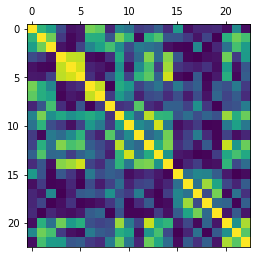

Number of selected features (columns): 23, 23
[1]
Plotting pca for true labels...
pca labels: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


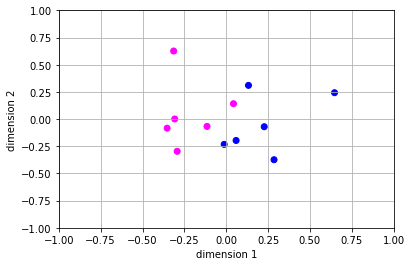

Plotting two clusters...
pca labels: [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]


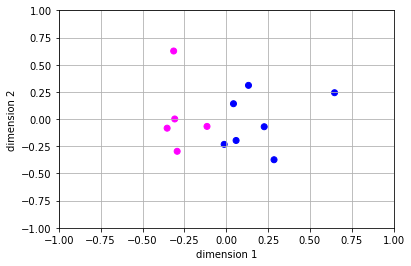

Comparing true labels: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1] with predicted: [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Adjusted rand score: 0.664819944598338
Predicted labels: [1]
If cluster labels fit to true encoded labels: ['orientation']
Plotting clusters with new predicted data
pca labels: [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]


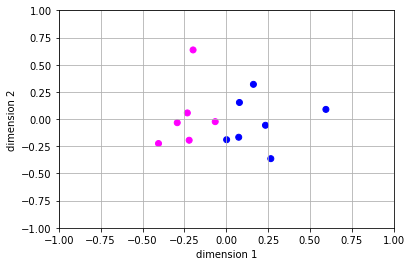

Plotting clusters with new predicted labels in another color
pca labels: [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 2]


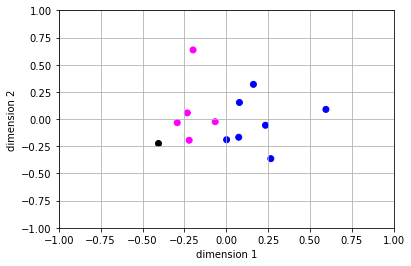

In [25]:
# compute true labels
labels = []
labels_grouped = df.groupby(['Session ID', 'Period'])['Period']
for idx, label in labels_grouped:
    labels.append(label.unique()[0])
print('Labels to decode: {}'.format(labels))
labels = [encoded_period.get(n, n) for n in labels]
print('Decoded labels: {}'.format(labels))

# compute features (columns)
df_to_cluster = compute_features(df, ['Session ID', 'Period'])
df_to_predict_period = compute_features(df_to_predict, ['Session ID', 'Period'])
print('Number of computed features (columns): {}, {}'.format(len(df_to_cluster.columns), len(df_to_predict_period.columns)))

df_predicted_period = analyze_dataframe(df_to_cluster, labels, df_to_predict_period)

In [26]:
df_predicted_period

,,Mean Abs Diff Pitch,Mean Abs Diff Yaw,Mean Abs Diff Roll,Sum Abs Diff Pitch,Sum Abs Diff Yaw,Sum Abs Diff Roll,Max Abs Diff Pitch,Max Abs Diff Yaw,Max Abs Diff Roll,Mean Pitch,...,Sum Roll,Max Pitch,Max Yaw,Min Pitch,Min Yaw,Pitch Group0,Pitch Group1,Pitch Group2,Pitch Group3,pred clusters
Session ID,Period,,,,,,,,,,,,,,,,,,,,,
session89,predict,-1.412699,-2.103741,-1.744584,0.174335,-0.17793,-0.184332,0.420059,-0.106431,-0.747903,-1.501081,...,-1.227605,-2.130184,-5.70215,0.219317,1.226565,0.457525,1.285614,1.090622,-1.404544,1


### Cluster and predict labels for splits with sklearn

Number of splits: 
Counter({200: 37, 145: 2, 86: 1, 144: 1, 155: 1, 148: 1, 197: 1, 73: 1, 64: 1, 165: 1})
Take only splits with min 0.9 of normal split lenght. Number of splits: 38
Counter({200: 37, 197: 1})
Labels to decode: ['freelook', 'freelook', 'orientation', 'orientation', 'orientation', 'orientation', 'orientation', 'orientation', 'freelook', 'freelook', 'orientation', 'orientation', 'orientation', 'freelook', 'freelook', 'orientation', 'orientation', 'orientation', 'orientation', 'orientation', 'freelook', 'orientation', 'orientation', 'orientation', 'orientation', 'freelook', 'freelook', 'orientation', 'orientation', 'orientation', 'freelook', 'freelook', 'orientation', 'orientation', 'orientation', 'orientation', 'orientation', 'orientation']
Decoded labels: [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
['Pitch', 'Yaw', 'Roll']
['Abs Diff Pitch', 'Abs Dif

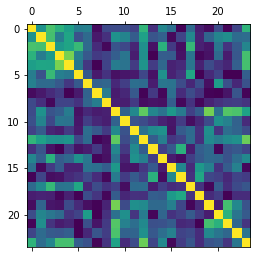

Number of selected features (columns): 24, 24
[1 1 1 1 1 1]
Plotting pca for true labels...
pca labels: [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


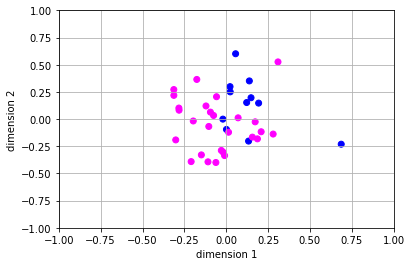

Plotting two clusters...
pca labels: [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]


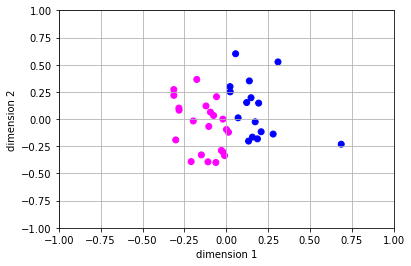

Comparing true labels: [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1] with predicted: [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Adjusted rand score: 0.257631726945003
Predicted labels: [1, 1, 1, 1, 1, 1]
If cluster labels fit to true encoded labels: ['orientation', 'orientation', 'orientation', 'orientation', 'orientation', 'orientation']
Plotting clusters with new predicted data
pca labels: [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


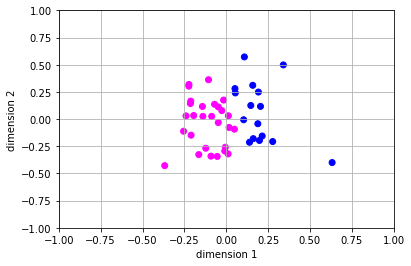

Plotting clusters with new predicted labels in another color
pca labels: [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]


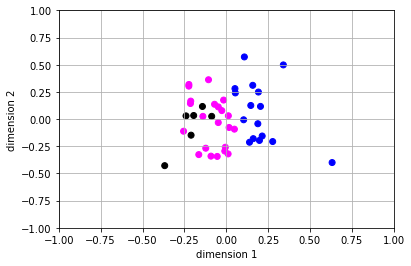

In [27]:
# select splits to take and compute true labels
splits_to_cluster_list, split_labels = compute_splits_metadata()

# compute features (columns)
df_to_cluster_splits = compute_features(df, 'Split')
df_to_predict_splits = compute_features(df_to_predict, 'Split')
print('Number of computed features (columns): {}, {}'.format(len(df_to_cluster_splits.columns), len(df_to_predict_splits.columns)))

# select splits (rows)
df_to_cluster_splits = df_to_cluster_splits.loc[splits_to_cluster_list, :]
print('Number of selected splits (rows): {}'.format(len(df_to_cluster_splits)))

df_predicted_splits = analyze_dataframe(df_to_cluster_splits, split_labels, df_to_predict_splits)

In [28]:
df_predicted_splits

,Mean Abs Diff Pitch,Mean Abs Diff Yaw,Mean Abs Diff Roll,Max Abs Diff Pitch,Max Abs Diff Yaw,Max Abs Diff Roll,Min Abs Diff Pitch,Min Abs Diff Yaw,Min Abs Diff Roll,Mean Pitch,...,Min Pitch,Min Yaw,Min Roll,Pitch Group0,Pitch Group1,Pitch Group2,Pitch Group3,Pitch Group4,Pitch Group5,pred clusters
Split,,,,,,,,,,,,,,,,,,,,,
9,-0.907520,0.068140,-1.078917,-0.714305,0.612825,-1.329834,-0.719433,-0.540395,-0.730425,-0.073198,...,-0.133106,1.642416,0.477070,-0.427092,-0.129204,0.611030,0.023374,-0.501025,-0.436752,1
10,-0.202925,-1.409288,-1.218388,1.372821,0.502978,-1.097615,4.159934,-0.231768,-0.577309,-1.179406,...,-0.310331,1.484590,0.476377,-0.427092,1.625218,0.320098,-1.307995,-0.501025,-0.436752,1
11,-1.587765,-2.397177,-2.008477,-0.113242,-1.412861,-1.576704,-0.259186,-0.461133,-0.675280,-2.639124,...,-0.722524,3.467451,0.386767,3.948225,1.844520,-1.584187,-1.351646,-0.501025,-0.436752,1
12,-0.417293,-0.721249,-1.100810,-0.758653,-0.598304,-0.987076,-0.091338,-0.227277,0.106724,-0.308198,...,0.321745,0.049710,0.954767,-0.427092,0.065732,1.378033,-0.784177,-0.501025,-0.436752,1
13,-0.807425,-1.191652,-1.220259,-0.721540,-0.466843,-0.941775,-0.549446,-0.359081,-0.668240,-0.836214,...,0.348352,0.214217,0.687754,-0.427092,0.479970,1.351585,-1.133389,-0.501025,-0.436752,1
14,-0.793214,-1.441211,-1.222072,-0.921644,-0.979341,-0.856288,-0.339903,-0.212906,0.494499,-0.817905,...,0.022498,1.506789,1.001142,-0.427092,0.431236,1.668966,-1.351646,-0.501025,-0.436752,1
